In [113]:
# ===== ANÁLISIS DE PLAZOS FIJOS - LECTURA DIRECTA DE ARCHIVOS =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [114]:
# --- CONFIGURACIÓN ---
archivo_principal = "sample_data/Plazo_fijos_19_11_2025.csv"
archivo_otros = "sample_data/Plazo_fijos_otros_bancos.csv"


In [115]:
# --- FUNCIÓN PARA LIMPIAR NÚMEROS CON COMAS Y PUNTOS ---
def clean_currency(x):
    """Convierte '1.234.567,89', '"173095,89"', '684000' → float correcto"""
    if pd.isna(x) or x in ['', ' ', None]:
        return 0.0
    s = str(x).strip()
    # Eliminar comillas, espacios, símbolos
    s = s.replace('"', '').replace("'", "").replace('$', '').replace(' ', '').replace('ARS', '').replace('AR$', '')
    # Detectar si la coma es decimal (formato argentino)
    if ',' in s and s.count(',') == 1 and ('.' not in s or s.rfind(',') > s.rfind('.')):
        s = s.replace('.', '')  # quitar separadores de miles
        s = s.replace(',', '.')  # coma → punto decimal
    else:
        s = s.replace(',', '')  # si no, quitar comas
    try:
        return float(s)
    except:
        print(f"ADVERTENCIA: No se pudo convertir '{x}' → usando 0.0")
        return 0.0

In [116]:
# --- LEER ARCHIVO PRINCIPAL ---
try:
    df1 = pd.read_csv(archivo_principal, encoding='utf-8', sep=',', quotechar='"')
    print(f"Archivo principal '{archivo_principal}' leído correctamente. {len(df1)} filas.")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo '{archivo_principal}'. Asegúrate de que esté en la carpeta.")
    raise
except Exception as e:
    print(f"ERROR al leer el archivo principal: {e}")
    raise

Archivo principal 'sample_data/Plazo_fijos_19_11_2025.csv' leído correctamente. 39 filas.


In [117]:
# --- LEER ARCHIVO OTROS BANCOS ---
try:
    df2 = pd.read_csv(archivo_otros, encoding='utf-8', sep=',', quotechar='"')
    print(f"Archivo otros bancos '{archivo_otros}' leído correctamente. {len(df2)} filas.")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo '{archivo_otros}'.")
    raise
except Exception as e:
    print(f"ERROR al leer el archivo de otros bancos: {e}")
    raise

Archivo otros bancos 'sample_data/Plazo_fijos_otros_bancos.csv' leído correctamente. 17 filas.


In [118]:
# --- LIMPIAR Y ESTANDARIZAR DATOS ---
# Banco principal
df1['Capital Inicial'] = df1['Capital Inicial'].apply(clean_currency)
df1['Interés'] = df1['Interés'].apply(clean_currency)
df1['TNA'] = df1['TNA'].apply(clean_currency)
df1['Fecha Vencimiento'] = pd.to_datetime(df1['Fecha Vencimiento'], format='%d/%m/%Y', errors='coerce')

In [119]:
# Otros bancos
df2['Capital Inicial'] = df2['Capital Inicial'].apply(clean_currency)
df2['Ganancias'] = df2['Ganancias'].apply(clean_currency)
df2['TNA'] = df2['TNA'].apply(clean_currency)
df2['Fecha de Vencimiento'] = pd.to_datetime(df2['Fecha de Vencimiento'], format='%d/%m/%Y', errors='coerce')
df2 = df2.rename(columns={'Ganancias': 'Interés', 'Fecha de Vencimiento': 'Fecha Vencimiento'})

In [120]:
# --- UNIFICAR DATAFRAMES ---
df_unificado = pd.concat([
    df1[['Fecha Vencimiento', 'Capital Inicial', 'Interés', 'TNA', 'Estado']].copy(),
    df2[['Fecha Vencimiento', 'Capital Inicial', 'Interés', 'TNA']].assign(Estado='ACTIVO')
], ignore_index=True)

In [121]:
# Eliminar filas inválidas
df_unificado = df_unificado.dropna(subset=['Fecha Vencimiento', 'Interés', 'Capital Inicial', 'TNA'])
print(f"\nTotal plazos unificados: {len(df_unificado)}")


Total plazos unificados: 55


In [122]:
# --- FECHA ACTUAL DINÁMICA ---
hoy = pd.Timestamp('today').normalize()
print(f"\nFecha de análisis: {hoy.strftime('%d/%m/%Y')}")


Fecha de análisis: 16/12/2025


In [123]:
# --- CAPITAL ACTIVO Al Dia de Hoy ---
df_activos = df_unificado[df_unificado['Fecha Vencimiento'] > hoy].copy()
capital_activo = df_activos['Capital Inicial'].sum()
tna_ponderado = (df_activos['Capital Inicial'] * df_activos['TNA']).sum() / capital_activo if capital_activo > 0 else 0

print(f"\nCAPITAL ACTIVO TOTAL (al {hoy.strftime('%d/%m/%Y')}): ${capital_activo:,.2f}")
print(f"TNA PROMEDIO PONDERADO: {tna_ponderado:.5f}%")


CAPITAL ACTIVO TOTAL (al 16/12/2025): $99,890,000.00
TNA PROMEDIO PONDERADO: 30.47858%


In [124]:
# --- DIAGNÓSTICO: INTERESES MAYORES A $1.5M (deben ser error) ---
print("\n=== DIAGNÓSTICO: INTERESES SOSPECHOSOS (> $1.5M) ===")
sospechosos = df_unificado[df_unificado['Interés'] > 1_500_000]
if len(sospechosos) > 0:
    for _, row in sospechosos.iterrows():
        print(f"  ALERTA: {row['Fecha Vencimiento'].strftime('%d/%m/%Y')} | Interés: ${row['Interés']:,.2f} | Capital: ${row['Capital Inicial']:,.0f}")
else:
    print("  Ningún interés sospechoso detectado.")


=== DIAGNÓSTICO: INTERESES SOSPECHOSOS (> $1.5M) ===
  Ningún interés sospechoso detectado.


In [125]:
# --- DIAGNÓSTICO: 10 PLAZOS CON MAYOR INTERÉS ---
print("\n=== DIAGNÓSTICO: 10 PLAZOS CON MAYOR INTERÉS ===")
diag = df_unificado[['Fecha Vencimiento', 'Interés', 'Capital Inicial', 'TNA']].copy()
diag = diag.nlargest(10, 'Interés')
for _, row in diag.iterrows():
    print(f"  {row['Fecha Vencimiento'].strftime('%d/%m/%Y')} → Interés: ${row['Interés']:,.2f} | Capital: ${row['Capital Inicial']:,.0f} | TNA: {row['TNA']:.2f}%")


=== DIAGNÓSTICO: 10 PLAZOS CON MAYOR INTERÉS ===
  09/12/2025 → Interés: $1,089,315.07 | Capital: $35,500,000 | TNA: 35.00%
  27/10/2025 → Interés: $1,022,278.08 | Capital: $13,300,000 | TNA: 45.25%
  08/10/2025 → Interés: $764,876.71 | Capital: $19,800,000 | TNA: 47.00%
  26/11/2025 → Interés: $684,000.00 | Capital: $15,200,000 | TNA: 54.00%
  07/11/2025 → Interés: $651,994.52 | Capital: $20,340,000 | TNA: 39.00%
  03/11/2025 → Interés: $617,228.08 | Capital: $7,900,000 | TNA: 46.75%
  29/09/2025 → Interés: $596,431.51 | Capital: $13,250,000 | TNA: 53.00%
  28/11/2025 → Interés: $439,397.26 | Capital: $9,900,000 | TNA: 54.00%
  14/11/2025 → Interés: $434,958.90 | Capital: $10,800,000 | TNA: 49.00%
  29/10/2025 → Interés: $423,928.77 | Capital: $13,940,000 | TNA: 37.00%


In [126]:
# --- GANANCIAS MENSUALES: SOLO LAS QUE SE COBRAN A PARTIR DE HOY ---
print("\nGANANCIAS MENSUALES FUTURAS (se cobran a partir de hoy):")
df_futuras = df_unificado[df_unificado['Fecha Vencimiento'] > hoy].copy()

if len(df_futuras) == 0:
    print("  No hay plazos que venzan después de hoy.")
else:
    df_futuras['Mes Cobro'] = df_futuras['Fecha Vencimiento'].dt.to_period('M').dt.to_timestamp()
    ganancias_futuras = df_futuras.groupby('Mes Cobro')['Interés'].sum().reset_index()
    ganancias_futuras = ganancias_futuras.sort_values('Mes Cobro')

    for _, row in ganancias_futuras.iterrows():
        mes = row['Mes Cobro'].strftime('%B %Y')
        print(f"  {mes}: ${row['Interés']:,.2f}")


GANANCIAS MENSUALES FUTURAS (se cobran a partir de hoy):
  December 2025: $967,339.76
  January 2026: $1,553,703.68


In [127]:
# --- ACUMULADO HISTÓRICO: INTERESES COBRADOS DESDE AGOSTO HASTA HOY ---
print("\n=== ACUMULADO DE INTERESES COBRADOS (desde agosto hasta hoy) ===")
df_historico = df_unificado[df_unificado['Fecha Vencimiento'] <= hoy].copy()

if len(df_historico) == 0:
    print("  No hay intereses cobrados aún.")
else:
    df_historico['Mes Cobro'] = df_historico['Fecha Vencimiento'].dt.to_period('M').dt.to_timestamp()
    acumulado_mensual = df_historico.groupby('Mes Cobro')['Interés'].sum().reset_index()
    acumulado_mensual = acumulado_mensual.sort_values('Mes Cobro')
    
    total_acumulado = 0
    for _, row in acumulado_mensual.iterrows():
        total_acumulado += row['Interés']
        mes = row['Mes Cobro'].strftime('%B %Y')
        print(f"  {mes}: ${row['Interés']:,.2f} → Acumulado: ${total_acumulado:,.2f}")
    
    print(f"\nTOTAL INTERESES COBRADOS HASTA HOY: ${total_acumulado:,.2f}")


=== ACUMULADO DE INTERESES COBRADOS (desde agosto hasta hoy) ===
  August 2025: $361,147.65 → Acumulado: $361,147.65
  September 2025: $2,149,108.14 → Acumulado: $2,510,255.79
  October 2025: $3,574,970.14 → Acumulado: $6,085,225.93
  November 2025: $4,052,472.59 → Acumulado: $10,137,698.52
  December 2025: $1,436,328.76 → Acumulado: $11,574,027.28

TOTAL INTERESES COBRADOS HASTA HOY: $11,574,027.28


In [128]:
# --- PROYECCIÓN 2026 - APORTE AL FINAL DEL MES (REALISTA) ---

CAPITAL_ACTUAL = 116_715_431  # Monto total colocado hoy (de los archivos). Esto hay que modificarlo si se cambia la fecha de análisis
APORTE_MENSUAL = 4_750_000     # Lo que se hira aportando (Arranque con 3.5M pero creo poder ahorrar eso). Puede modificarse según lo que se quiera proyectar

# ESCENARIOS 2026 (cambiar solo esta variable para probar)
# Para ser más conservador todavía, cambiar la línea
# ESCENARIO = "base" → ESCENARIO = "optimista"
ESCENARIO = "base"  # opciones: "base", "optimista", "pesimista"

tasas_2026 = {
    "base":       0.27,    # 27%  ← más probable
    "optimista":  0.22,    # 22%
    "pesimista":  0.38     # 38%
}

TNA_ANUAL = tasas_2026[ESCENARIO]
TASA_MENSUAL = TNA_ANUAL / 12

print(f"=== PROYECCIÓN PLAZOS FIJOS 2026 ===")
print(f"Escenario: {ESCENARIO.upper()} → TNA promedio 2026 = {TNA_ANUAL:.1%}")
print(f"Capital inicial: ${CAPITAL_ACTUAL:,.0f}")
print(f"Aporte mensual (al final): ${APORTE_MENSUAL:,.0f}\n")


=== PROYECCIÓN PLAZOS FIJOS 2026 ===
Escenario: BASE → TNA promedio 2026 = 27.0%
Capital inicial: $116,715,431
Aporte mensual (al final): $4,750,000



In [129]:
# ====================== PROYECCIÓN ======================
meses = 12
data = []
capital = CAPITAL_ACTUAL
interes_acumulado = 0

for mes in range(1, meses + 1):
    fecha = pd.Timestamp(2026, mes, 1)
    
    # Interés del mes (sobre capital al inicio del mes)
    interes_mes = capital * TASA_MENSUAL
    interes_acumulado += interes_mes
    
    # Capital después del interés
    capital_desp_interes = capital + interes_mes
    
    # Aporte al final del mes
    capital_final_mes = capital_desp_interes + APORTE_MENSUAL
    
    data.append({
        "Mes": fecha.strftime("%b"),
        "Capital Inicio": round(capital),
        "Interés": round(interes_mes),
        "Aporte": APORTE_MENSUAL,
        "Capital Final": round(capital_final_mes)
    })
    
    capital = capital_final_mes  # para el próximo mes

df = pd.DataFrame(data)

In [130]:
# ====================== RESULTADOS ======================
print(df.to_string(index=False, formatters={
    'Capital Inicio': '${:,.0f}'.format,
    'Interés':         '${:,.0f}'.format,
    'Aporte':          '${:,.0f}'.format,
    'Capital Final':   '${:,.0f}'.format
}))

print("\n" + "="*50)
print(f"INTERESES TOTALES 2026          → ${interes_acumulado:,.0f}")
print(f"APORTES TOTALES 2026            → ${APORTE_MENSUAL * 12:,.0f}")
print(f"CAPITAL FINAL 31-dic-2026       → ${capital:,.0f}")
print(f"Rendimiento efectivo anual 2026 → {(capital/CAPITAL_ACTUAL - 1)*100:.1f}%")
print("="*50)

Mes Capital Inicio    Interés     Aporte Capital Final
Jan   $116,715,431 $2,626,097 $4,750,000  $124,091,528
Feb   $124,091,528 $2,792,059 $4,750,000  $131,633,588
Mar   $131,633,588 $2,961,756 $4,750,000  $139,345,343
Apr   $139,345,343 $3,135,270 $4,750,000  $147,230,614
May   $147,230,614 $3,312,689 $4,750,000  $155,293,302
Jun   $155,293,302 $3,494,099 $4,750,000  $163,537,402
Jul   $163,537,402 $3,679,592 $4,750,000  $171,966,993
Aug   $171,966,993 $3,869,257 $4,750,000  $180,586,251
Sep   $180,586,251 $4,063,191 $4,750,000  $189,399,441
Oct   $189,399,441 $4,261,487 $4,750,000  $198,410,929
Nov   $198,410,929 $4,464,246 $4,750,000  $207,625,174
Dec   $207,625,174 $4,671,566 $4,750,000  $217,046,741

INTERESES TOTALES 2026          → $43,331,310
APORTES TOTALES 2026            → $57,000,000
CAPITAL FINAL 31-dic-2026       → $217,046,741
Rendimiento efectivo anual 2026 → 86.0%


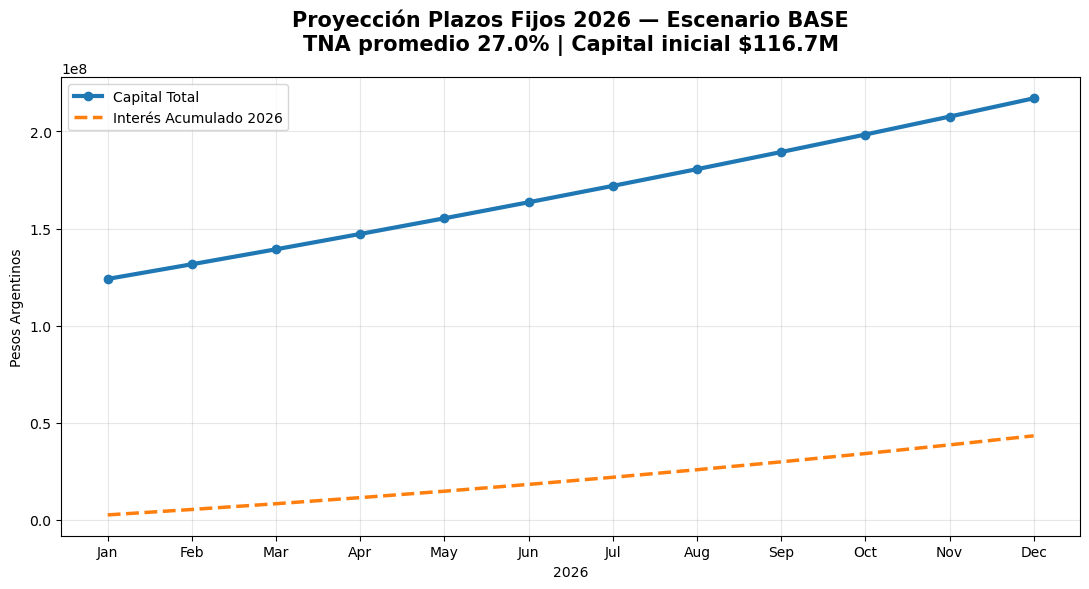

In [131]:
# --- GRÁFICO ---
plt.figure(figsize=(11, 6))
plt.plot(df["Capital Final"], label="Capital Total", marker='o', linewidth=3, color='#1f77b4')
plt.plot(df["Mes"], (df["Interés"].cumsum()), '--', label="Interés Acumulado 2026", color='#ff7f0e', linewidth=2.5)

plt.title(f"Proyección Plazos Fijos 2026 — Escenario {ESCENARIO.upper()}\nTNA promedio {TNA_ANUAL:.1%} | Capital inicial ${CAPITAL_ACTUAL/1e6:.1f}M", 
          fontsize=15, fontweight='bold', pad=20)
plt.ylabel("Pesos Argentinos")
plt.xlabel("2026")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [132]:
# --- EXPORTAR A EXCEL (OPCIONAL) ---
df.to_excel("sample_data/Proyeccion_PlazosFijos_2026.xlsx", index=False)
print("\nProyección exportada a 'Proyeccion_PlazosFijos_2026.xlsx'")


Proyección exportada a 'Proyeccion_PlazosFijos_2026.xlsx'
